In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import os
import datetime 

FILENAME_TRAIN = ['train_1/','train_2/','train_3/','train_4/', 'train_5/']
FILENAME_TEST = ['test_1/','test_2/','test_3/','test_4/', 'test_5']
FILENAME_MAG = ['platform1.txt','hall.txt','platform4.txt','platform3.txt', 'platform2.txt']
LOCATION = 'suwon'
DIR = '../../data/'

thres_list = [range(-91, -65), range(-87, -57), range(-92, -70), range(-91, -65), range(-92, -64)]
range_val = range(1,5)
rssi_range = [40]
area_thres1 = 0.0
area_thres2 = 1.0

test_slicer = 1

thres_ = []
range_ = []
decreassion_ = []


In [6]:

class wifimodel():
    def __init__(self, location,index):
        self.train_dir = f'{DIR}{location}/train/{FILENAME_TRAIN[index]}'
        self.test_dir = f'{DIR}{location}/test/{FILENAME_TEST[index]}'
        
        self.location = location
        self.model_df = pd.DataFrame()
        self.test_df = pd.DataFrame()

        self.fil_model_df = pd.DataFrame()
        self.fil_test_df = pd.DataFrame()

        self.SSID_list = []
        
        self.test_x_list = []
        self.test_y_list = []
        
        self.maxarea = 0
        self.maxarea2 = 0
        self.refwifi = []

        self.rssi_thres = 0
        self.range_num = 0
        self.range_num2 = 0

        self.thres = []
        self.range = []
        self.decreassion = []
        self.index = index
        self.parameter_list = []

        file_list = os.listdir(self.train_dir)
        for file in file_list:
            df = pd.read_csv(self.train_dir + file,
                             sep="\t", engine='python', encoding="UTF-8", header=None)
            df = pd.DataFrame(
                {"cnt": list(df.iloc[:, 0]), "x": list(df.iloc[:, 1]), "y": list(df.iloc[:, 2]),
                 "ADDR": list(df.iloc[:, 3]),
                 "SSID": list(df.iloc[:, 4]),
                 "RSSI": list(df.iloc[:, 5])})
            self.model_df = pd.concat([self.model_df, df])

        file_list = os.listdir(self.test_dir)
        for file in file_list:
            df = pd.read_csv(self.test_dir + file,
                             sep="\t", engine='python', encoding="UTF-8", header=None)
            df = pd.DataFrame(
                {"cnt": list(df.iloc[:, 0]), "x": list(df.iloc[:, 1]), "y": list(df.iloc[:, 2]),
                 "ADDR": list(df.iloc[:, 3]),
                 "SSID": list(df.iloc[:, 4]),
                 "RSSI": list(df.iloc[:, 5])})
            self.test_df = pd.concat([self.test_df, df])
        
        self.mag_df = pd.read_csv(f'../../mag/{location}/mag/{FILENAME_MAG[index]}', sep="\t", engine='python', encoding="cp949", header=None)

        self.ref_mag_df = copy.deepcopy(self.mag_df)
        
        for i in range(self.mag_df.shape[0]):
            for j in range(self.mag_df.shape[1]):
                if ((i % 6 == 0 ) and (j % 6 == 0) and (self.mag_df.iloc[i, j] != 0.0)):
                    self.maxarea += 1
        
        self.maxarea2 = sum(self.ref_mag_df[self.ref_mag_df != 0.0].count())
        self.mag_df[self.mag_df != 0.0] = np.nan

        self.maxX = self.mag_df.shape[0]
        self.maxY = self.mag_df.shape[1]

    def define_range(self, range_num, rssi_range_num):
        self.range_num = range_num
        self.rssi_range_num = rssi_range_num
    
    #RSSI 도 이용하기 대문에 ref_wifi와 rssiwifi를 정의해준다.
    def create_refwifi(self, rssi_thres):

        # 민혁 수정 2022 11 16
        # 파라미터 최적화를 위해 wifi 맵을 고정하기 위함
        # self.rssi_thres = rssi_thres
        self.rssi_thres = -999
        
        fil_model_df = self.model_df.loc[self.model_df['RSSI'] >= self.rssi_thres]
        self.fil_test_df = self.test_df.loc[self.test_df['RSSI'] >= self.rssi_thres]

        self.SSID_list = list(fil_model_df['SSID'].unique())
        self.test_x_list = self.fil_test_df['x'].unique()
        self.test_y_list = self.fil_test_df['y'].unique()
        
        self.refwifi = np.zeros((self.maxX, self.maxY, len(self.SSID_list)), dtype = np.int64)
        self.rssiwifi = np.zeros((self.maxX, self.maxY, len(self.SSID_list)), dtype = np.int64)
        
        self.rssi_max = np.max(fil_model_df['RSSI'])
        for i in range(fil_model_df.shape[0]):
            posx = fil_model_df.iloc[i, 1]
            posy = fil_model_df.iloc[i, 2]
            ssid = fil_model_df.iloc[i, 4]
            rssi = fil_model_df.iloc[i, 5]
            if(0 <= posx < self.maxX) and (0 <= posy < self.maxY):
                self.refwifi[int(posx)][int(posy)][self.SSID_list.index(ssid)] = 1
                #refwifi는 해당 ssid가 존재하면 1로 지정을 해줬는데 rssiwifi는 해당 ssid의 측정된 rssi 값으로 지정해준다.
                self.rssiwifi[int(posx)][int(posy)][self.SSID_list.index(ssid)] = rssi

    def test_all(self, thres, rang):
        tot_cnt = 0
        cnt = 0
        self.area_list = []
        coords_list = []
        fail_list = []
        

        for x in self.test_x_list:
            for y in self.test_y_list:
                compare_list = np.array([0 for i in range(len(self.SSID_list))])
                compare_list_rssi = np.array([0 for i in range(len(self.SSID_list))])

                compare_df = self.fil_test_df.loc[(self.fil_test_df["x"] == x) & (self.fil_test_df["y"] == y)]
                if compare_df.empty == False:
                    for i in range(compare_df.shape[0]):
                        if (compare_df.iloc[i, 4] in self.SSID_list):
                            compare_list[self.SSID_list.index(compare_df.iloc[i, 4])] = -1
                            #test data의 rssi 값으로 compare_list_rssi 값을 채워준다.
                            compare_list_rssi[self.SSID_list.index(compare_df.iloc[i, 4])] = compare_df.iloc[i, 5]

                    temp_wifi = self.refwifi - compare_list
                    temp_wifi = np.where(temp_wifi == 1, 0, temp_wifi)
                    
                    #기준 self.rssiwifi와 비교하기 위해 연산을 해주는데
                    #절대값을 해줘서 두 rssi값의 차이를 양수화해준다.
                    temp_rssi_wifi = abs(self.rssiwifi - compare_list_rssi)
                    #한쪽에는 ssid가 확인이 되는데 한쪽에는 확인이 안되게 되면
                    #RSSI 차이 연산시 0 과 측정된 rssi 측정치 (ex. -78) 의 차이를 유사도 비교에 사용하는 것은 무의미하기 때문에
                    #0 과 0이 아닌 값의 차이가 계산된 부분들을 다 0으로 바꿔준다.
                    temp_rssi_wifi = np.where(abs(temp_rssi_wifi) >= abs(self.rssi_max), 0, temp_rssi_wifi)

                    sum_temp = temp_wifi.sum(axis=2)
                    
                    #이제 RSSI 값을 이용하여 유사도 계산을 하게 될텐데
                    #RSSI 값을 비교할때 각 좌표에서의 RSSI 차이 값의 평균을 해주게 된다.
                    #그렇기 때문에 temp_wifi(self.refwifi - compare_list)를 해서 둘다 존재하는 ssid 개수가 0인 좌표에 대해서
                    #평균을 해줄때 분모에 0이 들어가면 안되기 때문에 해당 좌표에 대해서 0인 값을 0에 가까운 값으로 변환해준다.
                    sum_temp_for_rssi = copy.deepcopy(sum_temp)
                    sum_temp_for_rssi = np.where(sum_temp_for_rssi == 0, 0.00001, sum_temp)
                    #temp_rssi_wifi(rssi 차이)를 각 좌표마다 다 더해준다.
                    sum_rssi_temp = temp_rssi_wifi.sum(axis=2)
                    
                    #각 좌표마다 rssi 차이 평균을 계산한다.
                    sum_rssi_temp = sum_rssi_temp / sum_temp_for_rssi
                    
                    #SSID 둘다 존재하는 개수 (sum_temp)의 unique list 확인
                    sum_np = np.unique(sum_temp.flatten())[:: -1]
                    
                    if len(sum_np) <= self.range_num:
                        range_idx = len(sum_np) - 1
                    else:
                        range_idx = self.range_num

                    if range_idx == -1:
                        rangeval = 0
                    else:
                        #self.range_num에 따라 Bit vector 유사도 척도 값 확인
                        rangeval = np.unique(sum_np)[:: - 1][range_idx]
                    
                    #sum_rssi_temp 좌표 중에서 rangeval(Bit vector 유사도 척도) 이상의 좌표들만 이용해서
                    #rssi 값 차이의 평균의 unique list 계산
                    sum_rssi_np = np.unique(sum_rssi_temp[np.where(sum_temp >= rangeval)].flatten())
                    
                    #RSSI vector 유사도 척도 값 계산(Bit vector와 유사)
                    if len(sum_rssi_np) <= self.rssi_range_num:
                        range_idx = len(sum_rssi_np) - 1
                    else:
                        range_idx = self.rssi_range_num

                    if range_idx == -1:
                        rssi_rangeval = 0
                    else:
                        rssi_rangeval = np.unique(sum_rssi_np)[range_idx]
                    
                    #RSSI vector 유사도 척도값 이하(RSSI 값 차이가 작을 수록 유사하기 때문에), Bit vector 유사도 척도 값 이상인
                    #좌표들 확인
                    coords = np.where((sum_temp >= rangeval) & (sum_rssi_temp <= rssi_rangeval))

                    if (min(coords[0]) - 12 <= x <= max(coords[0]) + 12) and (min(coords[1]) - 12 <= y <= max(coords[1]) + 12):
                        cnt += 1
                        coords_list.append([x, y, coords])
                        self.area_list.append((max(coords[0]) - min(coords[0])) * (max(coords[1]) - min(coords[1]))
                                              / (self.maxX * self.maxY))
                    else:
                        fail_list.append([x, y, coords])
                    tot_cnt += 1
                    
                    if (tot_cnt % 100 == 0):
                        print(f"현재 진행 상황 : {tot_cnt} 회")
                        print(f"성공 횟수 : {cnt}회")
        
        
        print(f"test 횟수 : {tot_cnt}, 성공 횟수 : {cnt}")
        print('i: ' + str(self.index))
        if (cnt * 100 / tot_cnt) == 100:
            self.thres.append(thres)
            self.range.append(rang)
            self.decreassion.append(np.average(self.area_list))
            
            
        
        return coords_list, cnt / tot_cnt, np.average(self.area_list), fail_list
    
    

    def find_parameters(self):
        pass
    

In [8]:
for i in range(5):
    model = wifimodel(LOCATION,i)

    tot_acc_list = []
    tot_list_area = []

    tot_area_dist = []
    for thres in thres_list[i]:
        model.create_refwifi(thres)
        acc_list = []
        list_area = []
        area_dist = []
        for rang in range_val:
            for range_for_rssi in rssi_range:
                model.define_range(rang, range_for_rssi)
                cord, acc, ara, fail = model.test_all(thres, rang)
                acc_list.append(acc)
                list_area.append(ara)
                area_dist.append(model.area_list)
            tot_acc_list.append(acc_list)
            tot_list_area.append(list_area)
            tot_area_dist.append(area_dist)
    thres_.append(model.thres)
    range_.append(model.range)
    decreassion_.append(model.decreassion)

현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 300 회
성공 횟수 : 300회
test 횟수 : 313, 성공 횟수 : 313
i: 0
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 300 회
성공 횟수 : 300회
test 횟수 : 313, 성공 횟수 : 313
i: 0
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 300 회
성공 횟수 : 300회
test 횟수 : 313, 성공 횟수 : 313
i: 0
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 300 회
성공 횟수 : 300회
test 횟수 : 313, 성공 횟수 : 313
i: 0
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 300 회
성공 횟수 : 300회
test 횟수 : 313, 성공 횟수 : 313
i: 0
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 300 회
성공 횟수 : 300회
test 횟수 : 313, 성공 횟수 : 313
i: 0
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 300 회
성공 횟수 : 300회
test 횟수 : 313, 성공 횟수 : 313
i: 0
현재 진행 상황 : 100 회
성공 횟수 : 100회
현재 진행 상황 : 200 회
성공 횟수 : 200회
현재 진행 상황 : 300 회
성공 횟수 : 300회
test 횟수 : 313, 성공 횟수 : 313
i: 0
현재 진행 상황 : 100 회
성공 횟수 :

In [ ]:
idx0=decreassion_[0].index(min(decreassion_[0]))
thres_[0][idx0],range_[0][idx0]

# idx1=decreassion_[1].index(min(decreassion_[1]))
# thres_[1][idx1],range_[1][idx1]

idx2=decreassion_[2].index(min(decreassion_[2]))
thres_[2][idx2],range_[2][idx2]

idx3=decreassion_[3].index(min(decreassion_[3]))
thres_[3][idx3],range_[3][idx3]


(-81, 3)

In [58]:
df = pd.DataFrame(
        {'decreaion' : [min(decreassion_[0]),0,min(decreassion_[2]),min(decreassion_[3])],
        'thre' : [thres_[0][idx0],0,thres_[2][idx2],thres_[3][idx3]],
        'range' : [range_[0][idx0],0,range_[2][idx2],range_[3][idx3]]},
        index = ['1', '2', '3', '4']
    )
df

,decreaion,thre,range
1,0.661206,-52,1
2,0.000000,0,0
3,0.356346,-64,3
4,0.232358,-81,3


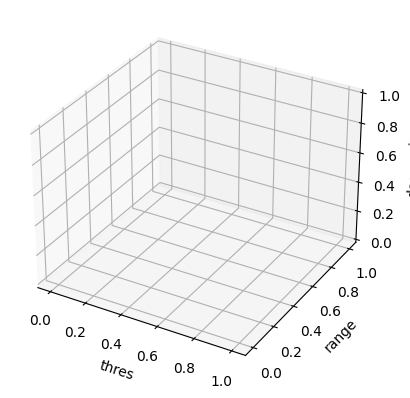

In [26]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = thres[0]
y = range_[0]
z = decreassion[0]

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('thres')
ax.set_ylabel('range')
ax.set_zlabel('decression')

plt.show()
